# GE Bracket

Geometry from the GE jet engine bracket challenge: https://grabcad.com/challenges/ge-jet-engine-bracket-challenge

Only one load case considered in the optimization: 35.6 kN vertical force

For numerical reasons, the force was rescaled by a factor of 0.01. Therefore, to obtain the actual compliance it is necessary to multiply the output by 10000 and to obtain the actual displament it is necessary to multiply the output by 100.

Ansys model:
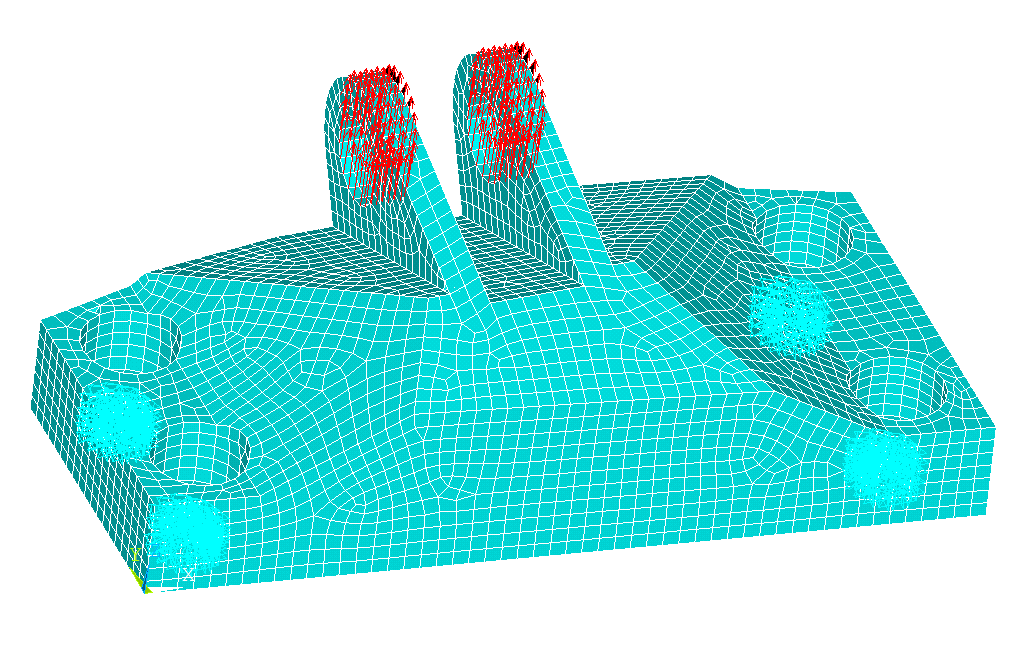

In [1]:
from pathlib import Path
from python.optimization import TopOpt
from python.postprocessor import Post3D

ANSYS_path = Path("C:/Program Files/ANSYS Inc/v202/ansys/bin/winx64/MAPDL.exe")
script_dir = Path("python/")
res_dir    = Path("results/")
mod_dir    = Path("models/")
TopOpt.set_paths(ANSYS_path, script_dir, res_dir, mod_dir)

In [2]:
# fiber: bamboo
rhofiber  = 700e-12 # t/mm^3
Efiber    = 17.5e3 # MPa
vfiber    = 0.04
CO2fiber  = 1.0565 # kgCO2/kg

# matrix: cellulose
rhomatrix = 990e-12 # t/mm^3
Ematrix   = 3.25e3
vmatrix   = 0.355 # MPa
CO2matrix = 3.8 # kgCO2/kg

Vfiber  = 0.5
Vmatrix = 1-Vfiber

Gfiber  = Efiber/(2*(1+vfiber))
Gmatrix = Ematrix/(2*(1+vmatrix))

Ex   = Efiber*Vfiber + Ematrix*Vmatrix
Ey   = Efiber*Ematrix / (Efiber*Vmatrix + Ematrix*Vfiber)
Gxy  = Gfiber*Gmatrix / (Gfiber*Vmatrix + Gmatrix*Vfiber)
nuxy = vfiber*Vfiber + vmatrix*Vmatrix
rho  = rhofiber*Vfiber + rhomatrix*Vmatrix

CO2mat = (rhofiber*Vfiber*CO2fiber + rhomatrix*Vmatrix*CO2matrix)/rho # kgCO2/kg
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

In [3]:
solver = TopOpt(inputfile='bracket', dim='3D_free', jobname='bracket',
                Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=vmatrix, Gxy=Gxy, volfrac=0.5, r_rho=10, r_theta=20, max_iter=30)
solver.optim()

print()
print('Total elapsed time     {:7.2f}s'.format(solver.time))
print('FEA time               {:7.2f}s'.format(solver.fea_time))
print('Derivation time        {:7.2f}s'.format(solver.deriv_time))
print('Variable updating time {:7.2f}s'.format(solver.mma.update_time))

print()
print('Mass : {:.2f} kg'.format(1000 * solver.mass(rho)))
print('Maximum displacement: {:.2f} mm'.format(100 * solver.disp_max()))
print('CO2 footprint: {:.2f} kgCO2'.format(1000 * solver.CO2_footprint(rho, CO2mat, CO2veh)))

Iteration   0...  compliance =    92.1799
Iteration   1...  compliance =   161.7290
Iteration   2...  compliance =   118.6754
Iteration   3...  compliance =   100.5554
Iteration   4...  compliance =    87.5908
Iteration   5...  compliance =    71.4991
Iteration   6...  compliance =    51.6368
Iteration   7...  compliance =    37.5001
Iteration   8...  compliance =    30.0101
Iteration   9...  compliance =    25.8147
Iteration  10...  compliance =    23.1576
Iteration  11...  compliance =    21.9065
Iteration  12...  compliance =    21.0263
Iteration  13...  compliance =    20.1281
Iteration  14...  compliance =    19.4868
Iteration  15...  compliance =    18.7525
Iteration  16...  compliance =    18.2712
Iteration  17...  compliance =    18.0506
Iteration  18...  compliance =    17.8157
Iteration  19...  compliance =    17.6615
Iteration  20...  compliance =    17.6204
Iteration  21...  compliance =    17.4445
Iteration  22...  compliance =    17.3564
Iteration  23...  compliance =    

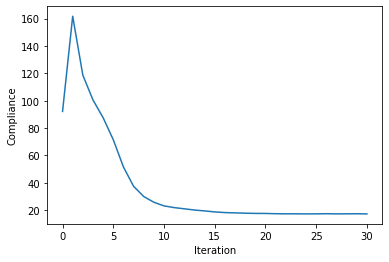

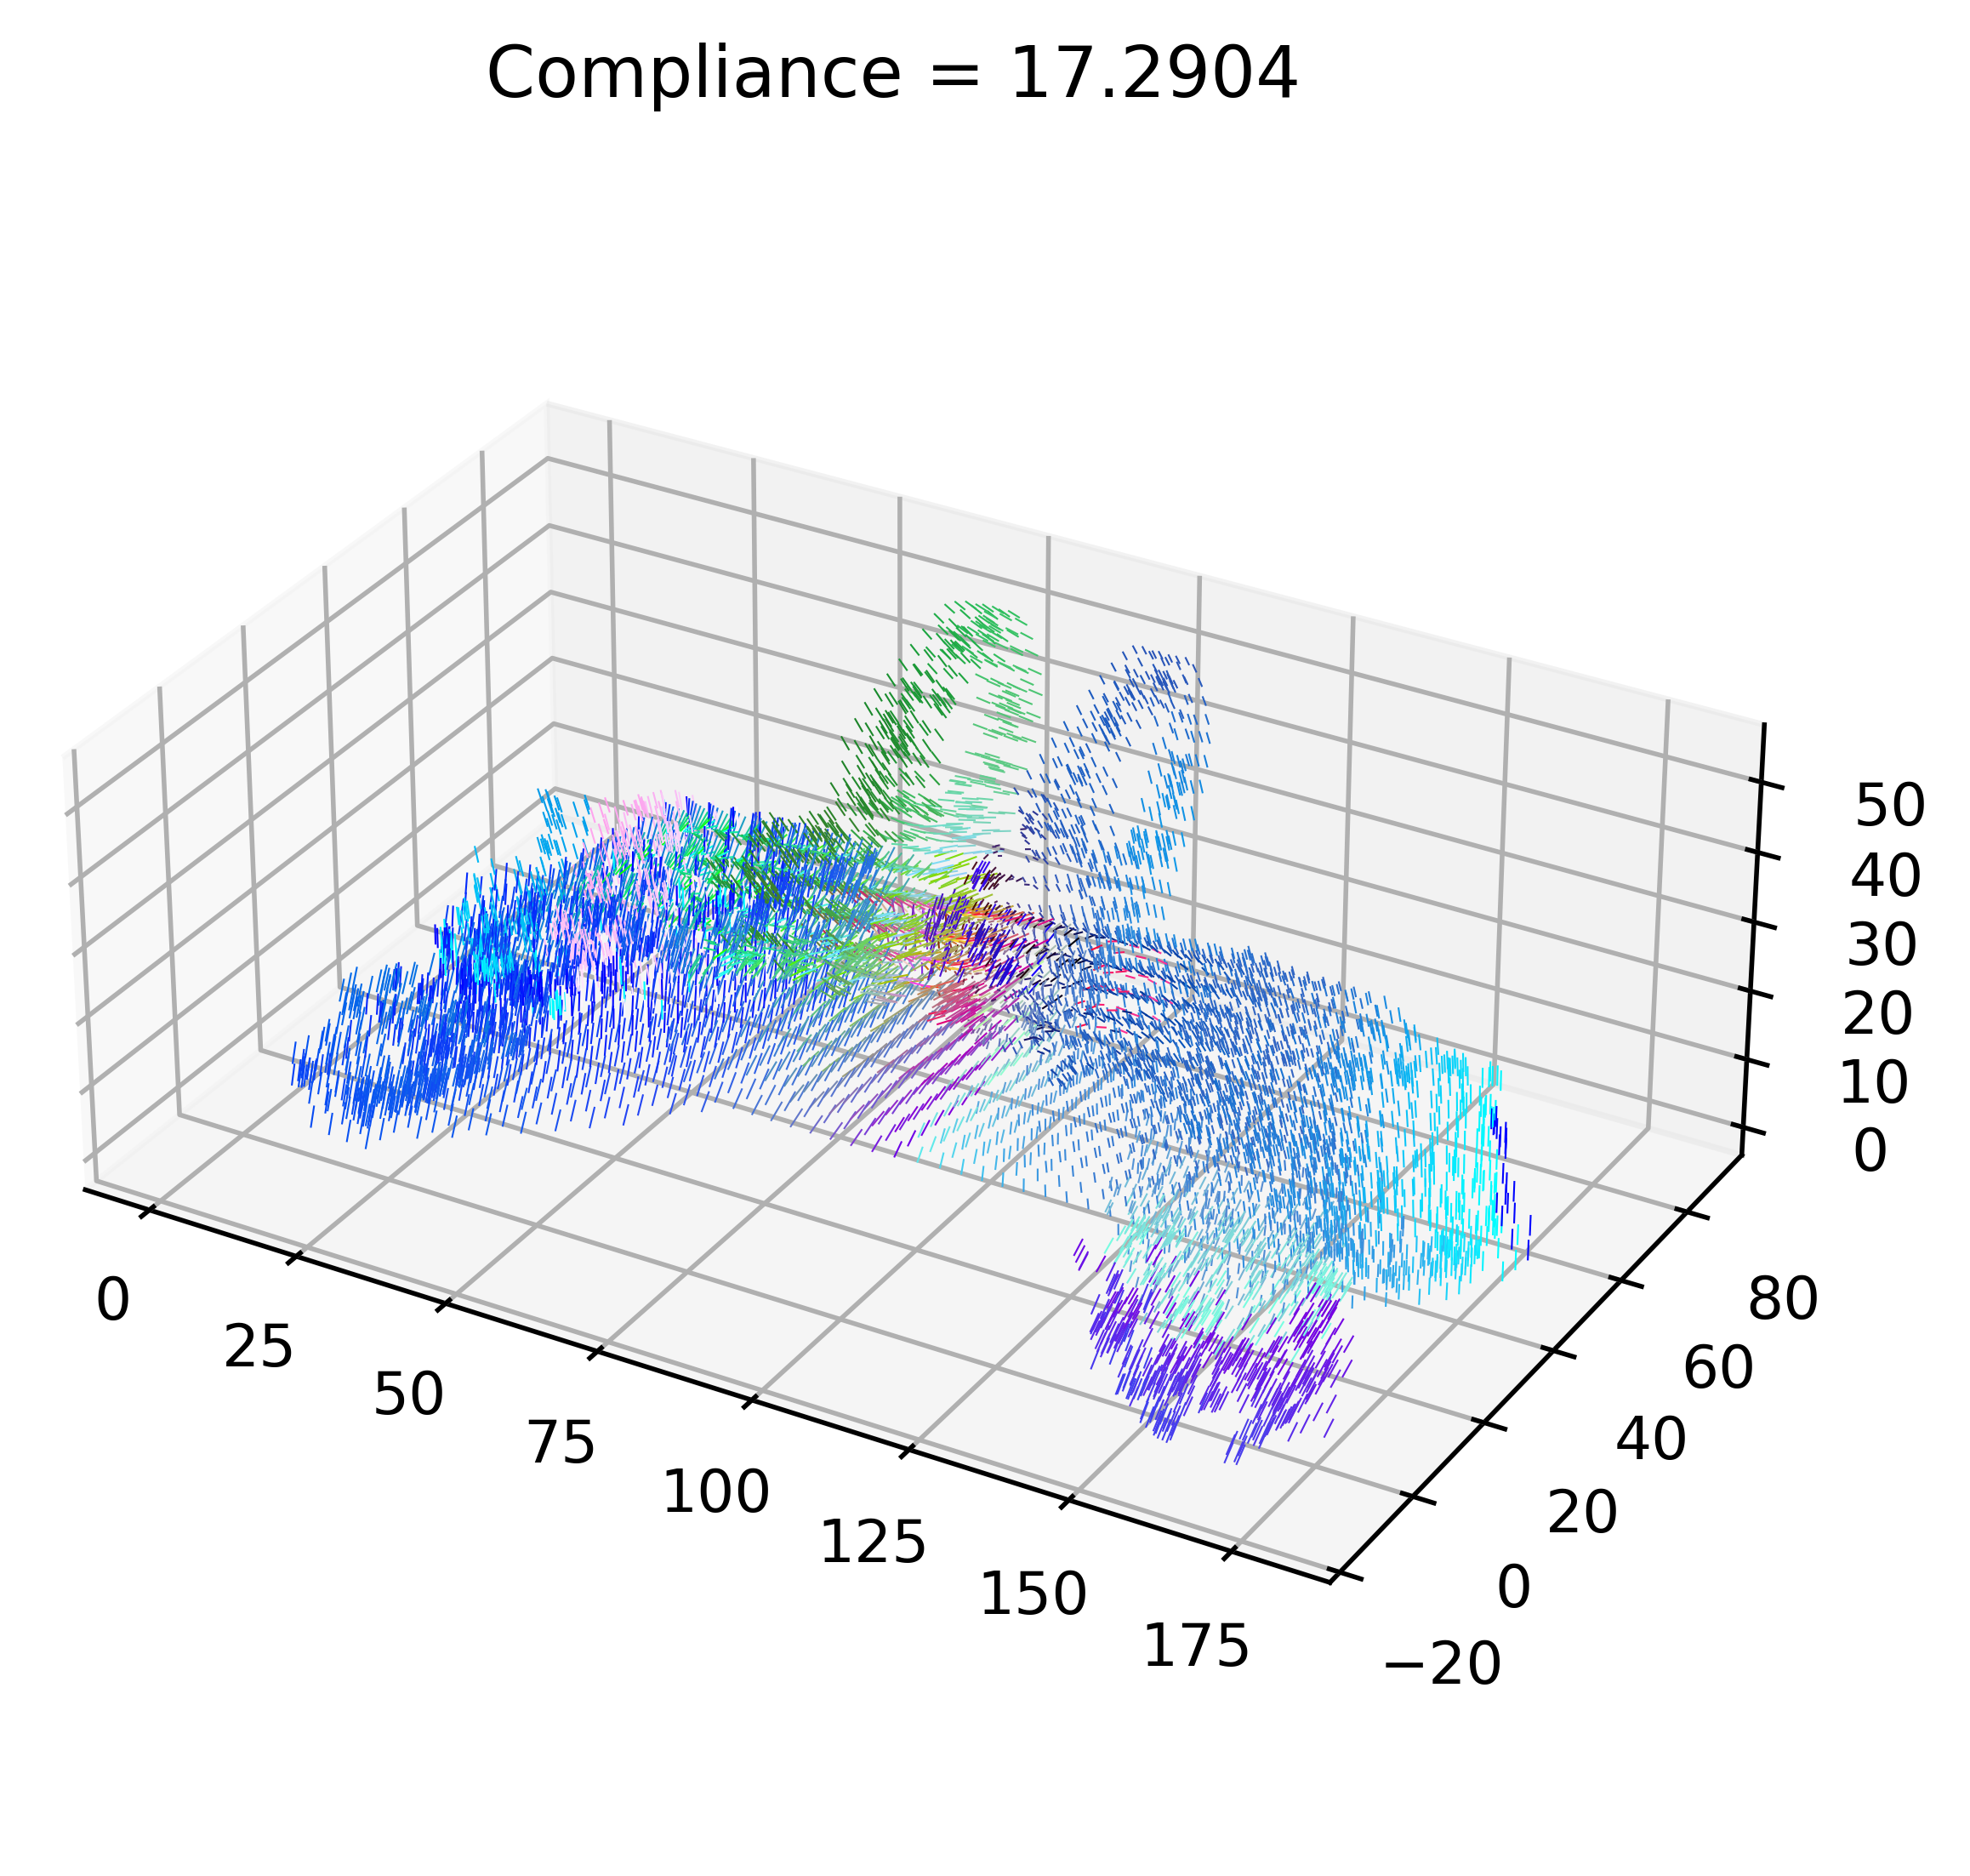

In [5]:
post = Post3D(solver)
post.plot_convergence()
post.plot_orientation()